# TDNN-NAS

TDNN-NAS aims to search for the special networks that meets the specific constraints. This tutorial will show how to employ the TDNN-NAS to achieve the search objective via either random algorithm or model predictive evolutionary algorithm (MPEA). 

Taking the coarse search space as an example, we demonstrate as follows.

1. Randomly sample a subnet from the trained supernet.
2. Apply MPEA to found the subnet that satifies the specific constraint, such as GPU latency.

More details about search implementation can be found in [EfficientTDNN](https://arxiv.org/abs/2103.13581).

In [ ]:
import warnings, random
warnings.filterwarnings("ignore")
random.seed(666)
import numpy, pandas
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from sugar.models.dynamictdnn import (
    TDNNPath, TDNNLatency, AccuracyPredictor, MinimizeError, ArchCoder, config2d, ea_solve)
from sugar.models import SpeakerModel, WrappedModel, veri_validate, batch_forward
from sugar.database import AugmentedUtterance
from sugar.data.voxceleb1 import veriset
from sugar.data.voxceleb2 import veritrain
from sugar.data.augmentation import augset
from sugar.metrics import print_size_of_model, profile, latency
from tqdm.notebook import tqdm

In [2]:
device = 'cuda:3'

## Randomly sampled subnets

This section shows how sample a subnet randomly from the trained supernet, e.g., `width2/width2.torchparams`.

1. Prepare the trained supernet.
2. Establish the coarse search space with kernel {1, 3, 5}, depth {2, 3, 4}, and width {0.25, 0.35, 0.5, 0.75, 1.0}.
3. Activate a subnet given a randomly sampled path.
4. Calibrate the batchnorm along the path via 6000 augmented training utterances.
5. Evaluate the subnet on the VoxCeleb1 clean test set, i.e., Vox1-O test set.

Note that the weights of the used supernet are downloaded from [huggingface](https://huggingface.co/mechanicalsea/efficient-tdnn).

### Prepare the trained supernet

We consider the training stage of width 2 and download the weights using huggingface hub.

In [3]:
repo_id = "mechanicalsea/efficient-tdnn"
supernet_filename = "width2/width2.torchparams"
supernet = WrappedModel.from_pretrained(
    repo_id=repo_id, supernet_filename=supernet_filename, subnet_filename=None
)[1]['supernet_model']

### Establish the coarse search space

The coarse search space is summarized as follows.

```python
cspace = [
    [2, 3, 4], # depth
    [128, 176, 256, 384, 512], # depth 1
    [128, 176, 256, 384, 512], # depth 2
    [128, 176, 256, 384, 512], # depth 3
    [128, 176, 256, 384, 512], # depth 4
    [128, 176, 256, 384, 512], # depth 5
    [1, 3, 5], # depth 1
    [1, 3, 5], # depth 2
    [1, 3, 5], # depth 3
    [1, 3, 5], # depth 4
    [1, 3, 5], # depth 5
    [384, 536, 768, 1152, 1536] # cat layer
]
```

In [4]:
cspace = supernet.module.__S__.space(mode=['kernel', 'depth', 'width1', 'width2'])
cpaths = TDNNPath(cspace)

### Activate a subnet given a randomly sampled path

The random strategy is used in search algorithm. The sampled path is estimated in terms of MACs, parameters, memory, and latency.

In [5]:
path = cpaths.sample()
supernet.config = path

input_size = [1, 48000]
macs, params = profile(supernet, input_size, device=device)
print(f"Subnet: {path}")
model_size = print_size_of_model(supernet)
avg_lat = latency(supernet, input_size, device=device)
print(f'MACs {macs} Params {params} Memory {model_size:.2f} MB Latency {avg_lat:.2f} ms on the {device}')

Subnet: (3, [384, 384, 256, 512], [5, 5, 5, 3], 384)
MACs 1.94G Params 7.55M Memory 29.18 MB Latency 14.89 ms on the cuda:3


### Calibrate the batchnorm along the path

We first prepare the training corpus, e.g., the development set of VoxCeleb2, and the augmentation corpus, e.g., the MUSAN and simulated rirs. Next, the batchnorm in the supernet is calibrated along the path via randomly sampled 6000 training utterances.

The reset of batchnorm is performed becuase the architectural differences between training paths and the sampled path that results in the mismath of statistics in the batchnorm.

Note that the musan corpus is splited as [VoxCeleb trainer](https://github.com/clovaai/voxceleb_trainer).

In [6]:
!unzip -o datalst.zip

Archive:  datalst.zip
  inflating: list_test_all2.txt      
  inflating: list_test_hard2.txt     
  inflating: veri_test2.txt          
  inflating: vox2.6000.txt           
  inflating: vox2_trainlst.txt       


In [7]:
vox1_root = "/workspace/datasets/voxceleb/voxceleb1/"
vox2_root = "/workspace/datasets/voxceleb/voxceleb2/"
musan_split_root = "/workspace/datasets/MUSAN/musan_split"
simulated_rirs_root = "/workspace/datasets/Room_Noise/RIRS_NOISES/simulated_rirs"

vox2_trainlst = "vox2_trainlst.txt"
wav_len = 96000
train, spks = veritrain(listfile=vox2_trainlst, rootdir=vox2_root, num_samples=wav_len)

random.shuffle(train.datalst)
train.datalst = train.datalst[:6000]

aug_wav = augset(musan_path=musan_split_root, rir_path=simulated_rirs_root, num_samples=wav_len)
trainset = AugmentedUtterance(train, spks, augment=aug_wav, mode='v2+')
train_loader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=5, drop_last=True)

for _ in range(1):
    batch_forward(train_loader, supernet, device=device)

The number of speakers is 5994


Forward Model: 100%|██████████| 46/46 [00:17<00:00,  2.57it/s]


### Evaluate the subnet on the VoxCeleb1 clean test set

The Vox1-O test set is considered to evalute the sampled architecture with the path. We do not use adaptive score normalization and take the whole utterance as an input to extract the speaker embedding.

In [8]:
def eval_veri(test_loader, network, p_target=0.01, device="cpu", vectors=None):
    eer, dcf, vec, scs = veri_validate(test_loader, network, p_target=0.01, device=device, ret_info=True, vectors=vectors)
    scs = pandas.DataFrame({'score': scs, 'enroll': test_loader.dataset.enrolls, 'test': test_loader.dataset.tests})
    labs = test_loader.dataset.labels
    eer = eer[0] * 100
    dcf = dcf[0]
    return eer, dcf, vec, scs

veritesto = "veri_test2.txt"
veri_testo = veriset(test2=veritesto, all2=None, hard2=None, rootdir=vox1_root, num_samples=0, num_eval=1)[0]
testo_loader = DataLoader(veri_testo, batch_size=1, shuffle=False, num_workers=0)

In [9]:
eero, dcfo, veco, scso = eval_veri(testo_loader, supernet, device=device)
print(f'Evaluate on Vox1-O: * EER/DCF {eero:.2f}%/{dcfo:.3f}')

Compute Scores: 100%|██████████| 37611/37611 [00:07<00:00, 5169.99it/s]


Evaluate on Vox1-O: * EER/DCF 1.44%/0.152


Using the ramdomly sampled path, we evaluate it on the VoxCeleb1 clean test set and obtain the EER to rank the model. To enable evaluation in a batch manner, we can pre-sample a large number of paths correspond to subnets, which can be evaluated in a computationally parallel manner.

## Apply model predictive evolutionary algorithm to found the subnet that satifies the specific constraint

This section demonstrate that applying model predictive evolutionary algorithm (MPEA) to found the special architecture that meet the specific constraints such as latency. Since the time cost in evaluating the Vox1-O test set is non-trivial, we build a latency table and an accuracy predictor in advance as well as simplify the process of evalution with a probably litte loss in performance to speed up the search.

Specifically, the search is performed via python package [geatpy](https://github.com/geatpy-dev/geatpy), which the Genetic and Evolutionary Algorithm Toolbox for Python with high performance. This tool provide high-level interface to user.

We present the MPEA as follows.

1. Load model and table estimating accuracy and latency
2. Define search problem and conduct predictor-based evoluation algorihtm to find the best solution

The found subnet will be evaluated in EER, minDCF, MACs, parameters, memory, and latency.

### Load table estimating accuracy and latency

- Load the GPU latency table and the accuracy predictor
- Print Max/Min efficiency

**Important Metrics**:

- Max/Min MACs   :  83.47M ~ 1.93G
- Max/Min Params :  443.97K ~ 7.55M
- Max/Min Memory :  1.75MB ~ 28.96MB
- Max/Min GPU Latency: 7.77ms ~ 27.96ms 

In [10]:
lat_gpu = TDNNLatency("tdnn8m2g_latency_v100_80_300.yml")

metric = "EER"
ndims = sum([len(ci) for ci in cspace])
space_type = "Coarse"
acc_pred = AccuracyPredictor(ndims, pretrained=f"{metric}.{ndims}.{space_type}.pth.tar", device=device)

In [11]:
a_largest = (4, [512, 512, 512, 512, 512], [5, 5, 5, 5, 5], 1536)
a_smallest = (2, [128, 128, 128], [1, 1, 1], 384)
input_size = [1, 80, 300]

macs_max, params_max = profile(supernet.module.__S__.clone(a_largest), input_size, device=device)
macs_min, params_min = profile(supernet.module.__S__.clone(a_smallest), input_size, device=device)
memory_max = print_size_of_model(supernet.module.__S__.clone(a_largest))
memory_min = print_size_of_model(supernet.module.__S__.clone(a_smallest))
latgpu_max = lat_gpu.query(a_largest)
latgpu_min = lat_gpu.query(a_smallest)

print('Max/Min MACs\t\t: {} ~ {}'.format(macs_min, macs_max))
print('Max/Min Params\t\t: {} ~ {}'.format(params_min, params_max))
print('Max/Min Memory\t\t: {:.2f}MB ~ {:.2f}MB'.format(memory_min, memory_max))
print('Max/Min GPU Latency\t: {:.2f}ms ~ {:.2f}ms'.format(latgpu_min, latgpu_max))

Max/Min MACs		: 83.47M ~ 1.93G
Max/Min Params		: 443.97K ~ 7.55M
Max/Min Memory		: 1.76MB ~ 28.97MB
Max/Min GPU Latency	: 7.77ms ~ 27.96ms


### Define search problem and conduct predictor-based evoluation algorihtm to find the best solution

This problem is to optimize the accuracy under the custom constraint.

Here, `GPU latecny / CPU latency / MACs / Params`-`threshold` is the upper bound.

More details can be found on [Geatpy2](https://github.com/geatpy-dev/geatpy) Github and [Website](http://www.geatpy.com/).

The constrained architecture search problem can be solved as follows.

```python
def ea_solve(target, problem, encode='BG', NIND=50, MAXGEN=200, Pm=0.1, verbose=True):
    """
        Parameters
        ----------
            encode : Individual Encode
            NIND : Population Size
            MAXGEN : Maximal Generation
            Pm : Mutation Probability
            
        Return
        ------
            solution : Best Individual
    """
    ...
```

- Individual Encode: BG
- Population Size: 50
- Maximal Generation: 200
- Mutation Probability: 0.1

#### Problem: Optimize EER/DCF with GPU latency constraint

Since the GPU latency is within `7.77ms ~ 27.96ms`, we consider different latency constraints as follows.

- Constrant: $\{8, 9, 10, \dots, 24, 25\}$

In [12]:
class GPULatencyConstraint(MinimizeError):
    def __init__(self, arch_codec, acc_pred, lat_table, space_mode='coarse', threshold=50, name='GPULatency'):
        MinimizeError.__init__(self, arch_codec, acc_pred, lat_table, space_mode, threshold, name)
    
    def constraints(self, subnets):
        X = subnets
        lat = numpy.array([self.lat_table.query((x[0], x[1: 2+x[0]], x[2+x[0]: 3+2*x[0]], x[-1])) for x in X])
        exidx = numpy.where(lat >= self.threshold)
        return exidx

dims = ["depth"] + [f"width{i}" for i in range(5)] + [f"kernel{i}" for i in range(5)] + ["cat"]
dconfig = {d: cspace[i] for i, d in enumerate(dims)}
archcodec = ArchCoder(len(cspace), dconfig, config2d)

thresholds = numpy.linspace(8, 25, 18)
solutions = []

pbar = tqdm(thresholds, desc=f'{metric} {space_type}')
for threshold in pbar:
    problem = GPULatencyConstraint(archcodec, acc_pred, lat_gpu, space_mode=space_type, threshold=threshold)
    solution = ea_solve(metric, problem, MAXGEN=200, verbose=False)
    assert solution, f'No solutions! {threshold}'
    solution, info = solution    
    macs, params = profile(supernet.module.__S__.clone(solution), (1, 80, 300), device=device, format=False)
    solutions.append([threshold, solution, macs, params, info['ACC'], info['Latency']])
    pbar.set_postfix({metric: info['ACC'], 'Constraint': threshold, 'Latency': info['Latency']})

EER Coarse:   0%|          | 0/18 [00:00<?, ?it/s]

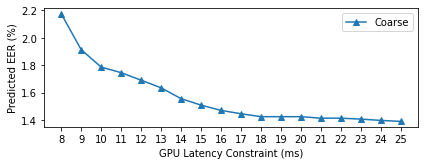

In [13]:
eer_coarse = numpy.asarray([[s[0], s[-2]] for s in solutions])
plt.figure(figsize=(6, 2.4))
plt.plot(eer_coarse[:, 0], eer_coarse[:, 1], marker='^', label='Coarse')
plt.ylabel('Predicted EER (%)')
plt.xlabel('GPU Latency Constraint (ms)')
plt.xticks(thresholds[::1])
plt.legend()
plt.tight_layout()
plt.show()

#### Reevaluate the performance of the best architecture

We conduct the evalution of the found subnet on the VoxCeleb1 clean test set in terms of EER, minDCF $_{0.01}$ , MACs, parameters, memroy, latency. Specifically, to speed up the process of evaluation, short-duration utterances are used to reset batchnorm. Two 4-second temporal segments are sampled at regular intervals from each test utterance. 2 × 2 = 4 cosine similarities are computed from each pair of segments, and their average is used as the score.

Note that some architectures require multiple time of reset of batchnorm to make statistics sufficient. Also, the same subnets are removed to reduce the time cost of evaluation.

In [14]:
wav_len = 32000
train, spks = veritrain(listfile=vox2_trainlst, rootdir=vox2_root, num_samples=wav_len)
random.shuffle(train.datalst)
train.datalst = train.datalst[:6000]
aug_wav = augset(musan_path=musan_split_root, rir_path=simulated_rirs_root, num_samples=wav_len)
trainset = AugmentedUtterance(train, spks, augment=aug_wav, mode='v2+')
train_loader = DataLoader(trainset, batch_size=32, shuffle=True, num_workers=5, drop_last=True)

eval_len = 64000
veri_testo = veriset(test2=veritesto, all2=None, hard2=None, rootdir=vox1_root, num_samples=eval_len, num_eval=2)[0]
testo_loader = DataLoader(veri_testo, batch_size=8, shuffle=False, num_workers=0)

The number of speakers is 5994


In [15]:
subnet_indices = []
subnet_eval = []
for i in range(len(solutions)):
    flag = True
    for j in range(len(solutions) - 1, i, -1):
        flag = False if solutions[i][1] == solutions[j][1] else True
        if not flag:
            subnet_eval.append(j)
            break
    if flag:
        subnet_indices.append(i)
        subnet_eval.append(i)
subnets = {i: solutions[i][1] for i in subnet_indices}

In [ ]:
ans = {}
for i, path in subnets.items():
    print(f'Subnet {i}: {path}')
    sampled_subnet = supernet.module.__S__.clone(path)
    macs, params = profile(sampled_subnet, (1, 80, 300), device=device)
    memory = print_size_of_model(sampled_subnet)
    lat = latency(sampled_subnet, (64, 80, 300), device=device)
    sampled_subnet = SpeakerModel(sampled_subnet, transform=supernet.module.__T__)
    cnt = 0
    while True:
        batch_forward(train_loader, sampled_subnet, device=device)
        eero, dcfo, _, _ = eval_veri(testo_loader, sampled_subnet, device=device)
        info = 'Performance: EER {:.2f}% minDCF {:.3f} MACs {} Params {} Memory {:.2f} MB GPU Latency {:.2f} ms'
        print(info.format(eero, dcfo, macs, params, memory, lat))
        cnt = cnt + 1
        if eero < 20 or cnt > 5: break
    assert i not in ans, i
    ans[i] = [path, '%.2f' % eero, '%.3f' % dcfo, macs, params, '%.2f' % memory, '%.3f' % lat]

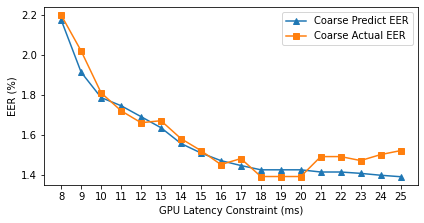

In [17]:
eer_coarse_act = numpy.asarray([float(ans[i][1]) for i in subnet_eval])
plt.figure(figsize=(6, 3.2))
plt.plot(eer_coarse[:, 0], eer_coarse[:, 1], marker='^', label='Coarse Predict EER')
plt.plot(eer_coarse[:, 0], eer_coarse_act, marker='s', label='Coarse Actual EER')
plt.ylabel('EER (%)')
plt.xlabel('GPU Latency Constraint (ms)')
plt.xticks(thresholds[::1])
plt.legend()
plt.tight_layout()
plt.show()

## Conclusion

This tutorial show how to sample a subnet from the trained supernet via the architectural configuration. The search process is conducted in the coarse space via model preditive evolutionary algorithm, which provides a insight to how to employ the EfficientTDNN in a more realistic situation while considering the computational constraints.

Please, cite EfficientTDNN if you use it for your research or business.

```bibtex
@article{speechbrain,
  title={{EfficientTDNN}: Efficient Architecture Search for Speaker Recognition in the Wild},
  author={Rui Wang and Zhihua Wei and Haoran Duan and Shouling Ji and Zhen Hong},
  year={2021},
  eprint={2103.13581},
  archivePrefix={arXiv},
  primaryClass={eess.AS},
  note={arXiv:2103.13581}
}
```